In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,5)
from scipy import signal
from numpy import fft
import import_ipynb
from IPython.display import Image, Audio

## Assumptions of DFT, STFT, and Windowing

Recall that the DFT assumes a continuous signal. When we use a STFT, the analysis window 'cuts' the signal, and this creates an isolated DFT which assumes that the 'end' point of this cropped signal joins to the 'beginning' of it (i.e., the input is periodic and continuous). When this is false (which is usually the case), it creates sudden 'jumps' or **discontinuities** in the signal input. This creates artifacts in the magnitude spectrum output.

To avoid these artifacts, we typically apply a **window** (i.e, envelope) function to our input signal to artificially reduce these discontinuities. 

"Windowing" reduces the amplitude of the discontinuities at the
boundaries of each finite sequence of samples. "Windowing" consists of multiplying
the time "slice" by a finite-length window with an amplitude that varies smoothly and gradually toward zero at the edges. (I.e., we are applying an envelope function that is tapered at the ends like a 'fade in' and 'fade out'). 
This makes the endpoints of the waveform "meet" and, therefore, results in a continuous waveform without sharp transitions. 

If the amplitude of the wave is smaller at the beginning and end of the window, then the spurious frequencies will be smaller in magnitude as well.

However, since we have now multiplied to signals together (input x envelope) we will see effects of both in the spectral content. (Recall that multiplication in the time domain is equivalent to convolution in the spectral domain.

If we examine the spectrum of a single sinusoid that has been 'windowed', the spectrum you
get in this case looks like a "smeared" version instead of a single peak. It appears as if energy at our one frequency component has leaked into other neighboring frequencies. This phenomenon is referred to as **spectral leakage** and it is typically desirable to choose a window that minimizes this leakage, while simultaneously pinpointing as accurately as possible the center frequency component.

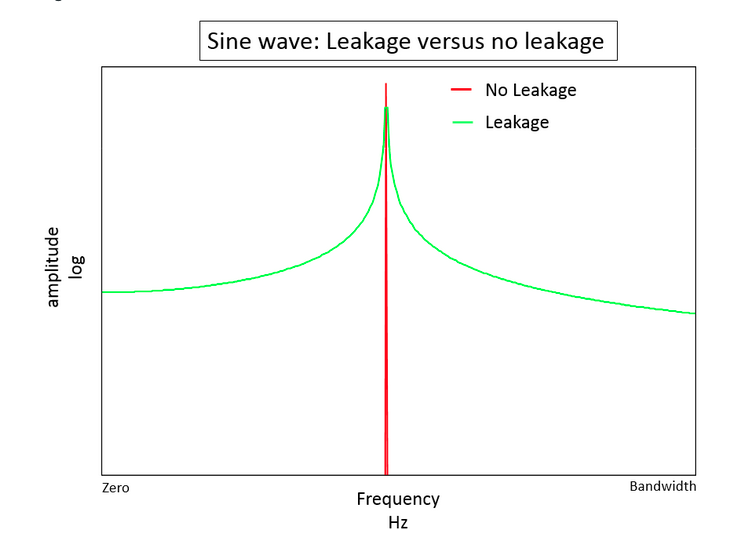

In [2]:
Image('../images/leakage.png',width=500)

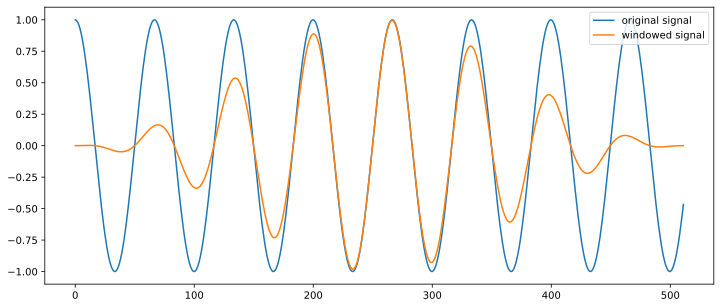

In [3]:
#Take a 15 hz cosine wave, grab a small fragment (512 samples) and multiply by hanning window of same size:
w = signal.hann(512)
t = np.linspace(0,1,1000)
s = np.cos(2*np.pi *15 * t[0:512]) #discontinuities by cropping the signal
line1 = plt.plot(s)
ws = s*w # multiplication of signal with hann window
line2 = plt.plot(ws)
plt.legend(['original signal', 'windowed signal'])

### Why are there different window "shapes"?

#### Windowing Functions

There are several different types of window functions that you can apply depending on the
signal. To understand how a given window affects the frequency spectrum, we need to
understand more about the frequency characteristics of windows.

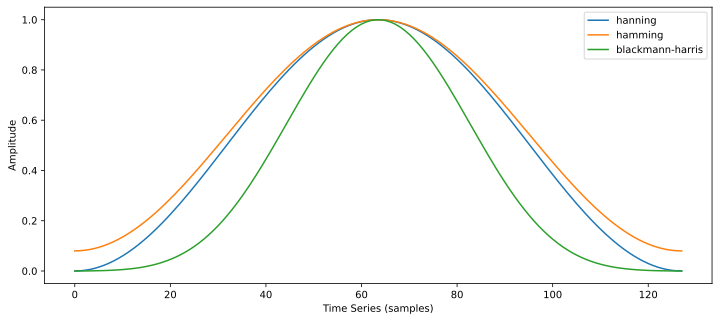

In [4]:
window = signal.hann(128)
window2 = signal.hamming(128)
window3 = signal.blackmanharris(128)

plt.plot(window)
plt.plot(window2)
plt.plot(window3)

plt.ylabel("Amplitude")
plt.xlabel("Time Series (samples)")
plt.legend(['hanning', 'hamming','blackmann-harris'])

An actual plot of a window shows that the frequency characteristic of the window itself (as a signal) is a continuous
spectrum with a **main lobe** and **side lobes**. 
The main lobe will be centered at each frequency
component of the time-domain signal, and the side lobes approach zero. The height of the side
lobes indicates the affect the windowing function has on frequencies around main lobes. 

If we think of this window as an input signal, let's examine it's spectral content in isolation:

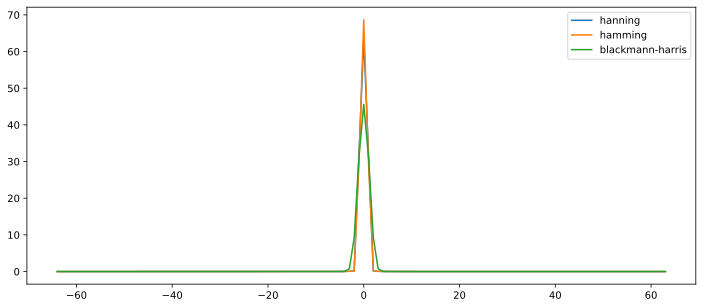

In [5]:
from scipy.fftpack import fftshift 
#take fft of window
N = 128 # window size in # of samples
Xw = np.fft.fft(window)
Xw2 = np.fft.fft(window2)
Xw3 = np.fft.fft(window3)
ns = np.arange(-N/2,N/2) #center the frequencies for positive and negative components
response = np.abs(fftshift(Xw))# plot of centered response of window -see fftshift docs-
response2 = np.abs(fftshift(Xw2))
response3 = np.abs(fftshift(Xw3))
plt.plot(ns, response, ns, response2, ns, response3) 
plt.legend(['hanning','hamming','blackmann-harris'])

Most commonly if you read about windows and their spectral properties, it will be shown on a logarithmic scale instead of linear. Let's look at the same window on a log scale:

### Choosing a window

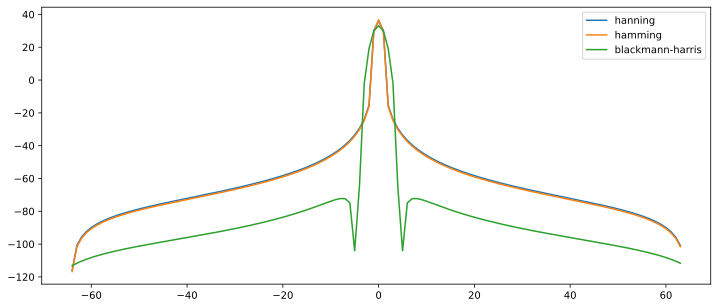

In [6]:
#plot on log scale to better show side lobes
X = np.abs(response)
X2 = np.abs(response2)
X3 = np.abs(response3)

plt.plot(ns,20*np.log10(X+0.0001/np.max(X)))
plt.plot(ns,20*np.log10(X2+0.0001/np.max(X2)))
plt.plot(ns,20*np.log10(X3+0.0001/np.max(X3)))
plt.legend(['hanning','hamming','blackmann-harris'])
#can add a tiny number to avoid error that happens when taking log of zero...

In addition, frequently you will see the log spectrum is normalized (so magnitude is divided by max magnitude):

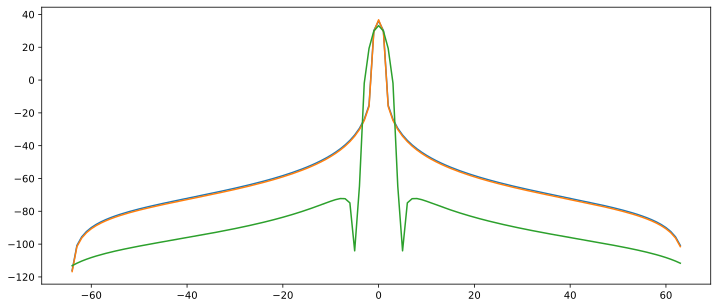

In [7]:
#plot on log scale; normalized magnitude - in this case it looks very similar.
plt.plot(ns,20*np.log10(response+0.0001/np.max(response)))
plt.plot(ns,20*np.log10(response2+0.0001/np.max(response2)))
plt.plot(ns,20*np.log10(response3+0.0001/np.max(response3)))

### STFT and zero-padding

Sometimes we will use a segment of audio (frame) that is relatively short. We now understand that while this allows better resolution in the time domain (seeing 'when' things happen), this compromises the frequency resolution (i.e., 'where' things happen). One 'trick' to gain increased frequency resolution for shorter slice of time is to use a technique called **zero padding**.

With zero-padding, we simply add a bunch of empty (zero-valued) samples to the end of our slice of audio. This, of course, increases the total length of the segment, giving increased frequency resolution. However, since the numbers added are all zeros, it does not harm or change the frequency content, since anything multiplied by zero will be zero.

### Fast Fourier Transform (FFT)

The usefulness of the DFT was extended greatly when a fast version was invented by Cooley and Tukey in 1965. This implementation, called the *fast Fourier transform* or FFT, reduces the computational complexity 

from $\mathcal{O}(N^2)$ to $\mathcal{O}(N\ log_2(N))$

The FFT is efficient because redundant or unnecessary computations are eliminated. For example, there's no need to perform a multiplication with a term that contains sin(0) or cos(0).

In addition, to take advantages of certain symmetrical properties of the DFT, the FFT algorithm has to operate on blocks of samples where the number of samples is a power of 2. 

### FFT in `numpy` and `scipy` packages

Both `numpy` and `scipy` have FFT functions. They are very similar. Since we'll mostly be working now with STFTs, it will be important for you to understand the parameters behind your STFT function, and that the calculation will make use of the FFT (not DFT)  which is why the window sizes are always powers of two. 

E.g., in the `numpy.fft.rfft` function it takes in `n` as the first argument 

`n: Number of points along transformation axis in the input to use. If n is smaller than the length of the input, the input is cropped. If it is larger, the input is padded with zeros. If n is not given, the length of the input along the axis specified by axis is used.`



Here's a handy function to find the next closest power of two...

In [10]:
### use zero-padding to improve frequency resolution:
import math
def NextPowerOfTwo(number):
    # Returns next power of two following 'number'
    return 2**(math.ceil(np.log2(number)))

The window length could be any number, if we choose 400 or 512 the fft size will be...

In [11]:
NextPowerOfTwo(520)

1024

In [12]:
NextPowerOfTwo(501)

512

By default the `rfft` (fft for real-valued input) implementation will zero-pad a signal to this next power of two (or to the FFT size specified).

Zero padding results in a 'smoother' interpretation of the magnitude components.

In [13]:
Audio('../uploaded_audio/soprano-E4.wav')

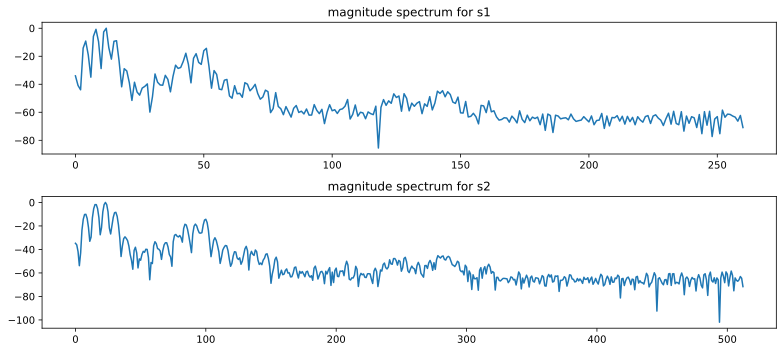

In [15]:
from scipy.io.wavfile import read
(fs, data) = read('../uploaded_audio/soprano-E4.wav')
import numpy as np
from numpy.fft import fftshift, rfft

M1 = 520 # window size
s1 = data[5000:5000+M1] * np.hamming(M1)  #single slice of data windowed
pad = np.zeros(NextPowerOfTwo(M1))
pad[:M1] = s1 # padded signal
s2 = pad
#s2 = np.concatenate((s1, pad)) # padded signal
X1 = rfft(s1)
X2 = rfft(s2)

fig, axs = plt.subplots(2, figsize=(11,5))


axs[0].plot(20*np.log10(abs(X1)/np.max(abs(X1)))) # change y-axis to db power spectrum to see more detail
axs[0].set_title('magnitude spectrum for s1')#x-axis values are bin indices, not frequencies
axs[1].plot(20*np.log10(abs(X2)/np.max(abs(X2))))
axs[1].set_title('magnitude spectrum for s2')
plt.tight_layout();



In [ ]:
window = signal.hann(526) #vary between 51 and 2048
plt.figure()
A = np.fft.rfft(window, 1028) # recall rfft is automatically zero-padding here...
freq = np.linspace(-(len(A)/2),len(A)/2, len(A))
mag = np.abs(A)
response = 20 * np.log10(mag/np.max(mag)) #normalize amplitudes convert to dB
plt.plot(freq, response)
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

### Hop size

When we apply a window to a portion of the signal, we necessarily remove content. Thus, if we align windows "end to end" there will be significant data loss. In order to minimize this data loss, we "hop" the frame (advance the window) by a fraction of its total length (usually around 50-75%). This way, when we add across the frames, we "get back" the amplitudes of the frequency components lost due to windowing.

A good rule of thum is to use 50\% overlap for the rectangular window, 75\% overlap for Hamming and Hanning windows, and 83\% (5/6) overlap for Blackman windows. 

In [ ]:
Image('../images/hopping.png')

In [ ]:
from IPython.display import Image
Image('../images/window_functions.gif', embed=True)

The ideal is to have narrowest possible main lobe, and lowest side-lobe level. 

Window features:  

**Rectangular window**
* main-lobe width: 2 bins (the minimum/ideal); side lobe level ~ -13db, moderate roll-off

**Hamming window**
* main-lobe width: 4 bins; side lobe level ~ -42db, low roll-off

**Hanning window**
* main-lobe width: 4 bins; side lobe level ~ -31db, high roll-off

**Four term Blackman-Harris window**
* main-lobe width: 8 bins; side lobe level ~ -92db! (below noise floor - we will not hear them), moderate-high roll-off


Typically, lower side lobes reduce leakage in the measured STFT but
increase the bandwidth of the major lobe. The side lobe roll-off rate is the asymptotic decay rate
of the side lobe peaks. By increasing the side lobe roll-off rate, you can reduce spectral leakage. However, by increasing the width of the main lobe, you reduce the spectral accuracy by 'spreading' the energy across multiple bins.

Thus,

■ If the amplitude accuracy of a single frequency component is more important than the
exact location of the component in a given frequency bin, choose a window with a wide
main lobe.  


In general, the Hanning (Hann) window is satisfactory in 95 percent of cases. It has good
frequency resolution and reduced spectral leakage. If you do not know the nature of the
signal but you want to apply a smoothing window, start with the Hanning window.


## Plotting Spectrogram

There are several functions where you can simply pass the raw audio data and have the function compute the STFT and resulting spectrogram for you. However, it is much better if you understand what you are doing, and plot the spectrogram yourself.

Matplotlib has a plotting tool called `pcolormesh` which can help us do exactly this. (see [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) for documentation.)

In [ ]:
#read audio
from scipy.io.wavfile import read
(fs, data) = read('../uploaded_audio/soprano-E4.wav')
#compute STFT
from scipy.signal import stft
#Function args:
'''scipy.signal.stft(x, fs=1.0, window='hann', nperseg=256, noverlap=None, 
nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, 
axis=- 1)'''
#Note default overlap 'None' actually is 50% - see docs.
f,t,Z = stft(data, fs=fs)
(numbins,numspectra) = Z.shape;
Z.shape


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.pcolormesh(t,f,20*np.log10(np.abs(Z)))
#plt.yscale('log')
#plt.ylim(10,10**4)

### ISTFT
Like the DFT, the STFT has the inverse transform. This way we can recover the original sound from the amplitude and phase spectrogram. Just like the DFT, where we overlap and add their spectra, now we we take inverse DFT of the spectral representation of every frame, and we then shift and sum ("overlap add") adding over the previous frame in such a way that we compensate for the windowing and we recover the output signal.

There are many properties to the STFT, many of which can make the ISTFT *not* invertible.  In short, depending on the frequency resolution of the STFT, it may become non-invertible.

It is important to understand that spectrogram data is not STFT data since we are only plotting magnitude and not phase. Unlike the output of STFT, the spectrogram contains no (direct) phase information. For this reason, it is not possible to reverse the process and generate a copy of the original signal from a magnitude spectrogram alone.